In [146]:
data = pandas.read_csv('targets.padded.100.tsv', sep='\t')
data.rename(columns = {'contig': '#chrom', 'start': 'chromStart', 'stop':'chromEnd'}, inplace = True)
data["#chrom"] = ["chr"+str(x) for x in data["#chrom"]]

In [147]:
data["gieStain"] = "gpos100"

In [148]:
data["chromStart"]= data["chromStart"] - 100000
data["chromEnd"]= data["chromEnd"] + 100000

In [149]:
data.to_csv(r'ideogram.txt', header=None, index=None, sep='\t', mode='a')

adding ideograms...
chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrX
chrY


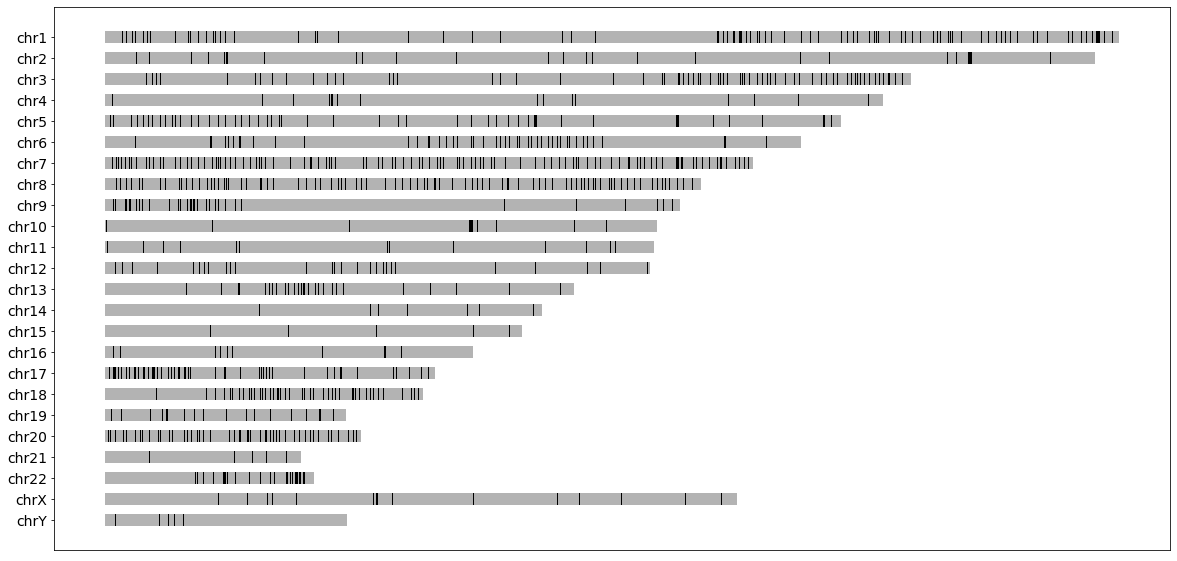

In [189]:
"""
Demonstrates plotting chromosome ideograms and genes (or any features, really)
using matplotlib.
1) Assumes a file from UCSC's Table Browser from the "cytoBandIdeo" table,
saved as "ideogram.txt". Lines look like this::
    #chrom  chromStart  chromEnd  name    gieStain
    chr1    0           2300000   p36.33  gneg
    chr1    2300000     5300000   p36.32  gpos25
    chr1    5300000     7100000   p36.31  gneg
2) Assumes another file, "ucsc_genes.txt", which is a BED format file
   downloaded from UCSC's Table Browser. This script will work with any
   BED-format file.
"""

from matplotlib import pyplot as plt
from matplotlib.collections import BrokenBarHCollection
import pandas


# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def chromosome_collections(df, y_positions, height,  **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        print(chrom)
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']

# Height of each ideogram
chrom_height = 1.2

# Spacing between consecutive ideograms
chrom_spacing = 1

# Height of the gene track. Should be smaller than `chrom_spacing` in order to
# fit correctly
gene_height = 0.2

# Padding between the top of a gene track and its corresponding ideogram
gene_padding = 0.1

# Width, height (in inches)
figsize = (20,10)

# Decide which chromosomes to use
chromosome_list = ['chr%s' % i for i in list(range(1, 23)) + ['X', 'Y']]

# Keep track of the y positions for ideograms and genes for each chromosome,
# and the center of each ideogram (which is where we'll put the ytick labels)
ybase = 0
chrom_ybase = {}
gene_ybase = {}
chrom_centers = {}

# Iterate in reverse so that items in the beginning of `chromosome_list` will
# appear at the top of the plot
for chrom in chromosome_list[::-1]:
    chrom_ybase[chrom] = ybase
    chrom_centers[chrom] = ybase + chrom_height / 2.
    gene_ybase[chrom] = ybase - gene_height - gene_padding
    ybase += chrom_height + chrom_spacing

# Read in ideogram.txt, downloaded from UCSC Table Browser
ideo = pandas.read_table(
    'ideogram.txt',
    skiprows=1,
    names=['chrom', 'start', 'end', 'name', 'gieStain']
)

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

# Add a new column for width
ideo['width'] = ideo.end - ideo.start

# Colors for different chromosome stains
color_lookup = {
    'gneg': (1., 1., 1.),
    'gneg': (.7, .7, .7),
    'gpos50': (.4, .4, .4),
    '75': (.2, .2, .2),
    'gpos100': (0., 0., 0.),
    'gpos5': (.8, .4, .4),
    'g': (.8, .8, .8),
    'g': (.9, .9, .9),
}

# Add a new column for colors
ideo['colors'] = ideo['gieStain'].apply(lambda x: color_lookup[x])




fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)



# Now all we have to do is call our function for the ideogram data...
print("adding ideograms...")
for collection in chromosome_collections(ideo, chrom_ybase, chrom_height):
    ax.add_collection(collection)

# Axes tweaking
ax.set_yticks([chrom_centers[i] for i in chromosome_list])
ax.set_yticklabels(chromosome_list, fontsize=14)
ax.axis('tight')
ax.set_xticks([])
plt.show()

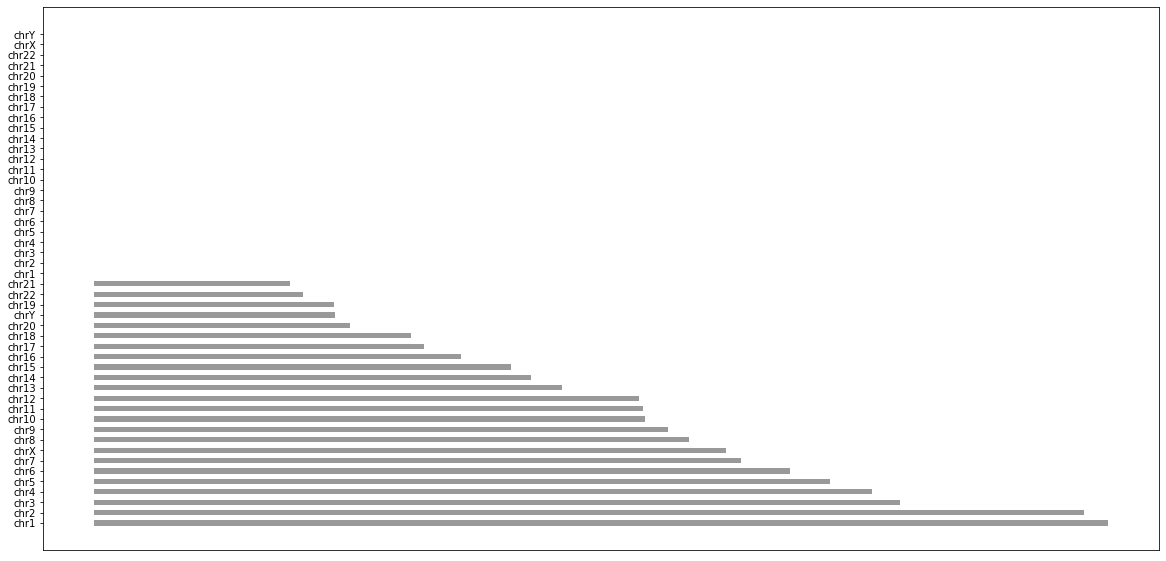

In [169]:
"""
Rough script to plot chromosome ideograms using data from UCSC
"""
from matplotlib import pyplot as plt
from matplotlib.collections import BrokenBarHCollection

color_lookup = {
                  'gpos100': (1., 1., 1.),
                'gneg': (.6, .6, .6),
                'gpos50': (.4, .4, .4),
                'gpos75': (.2, .2, .2),
               'gpos25': (0., 0., 0.),
                  'acen': (.8, .4, .4),
                  'gvar': (.8, .8, .8),
                 'stalk': (.9, .9, .9),
               }

height = 0.9
spacing = 0.9

def ideograms(fn):
    last_chrom = None
    fin = open(fn)
    fin.readline()
    xranges, colors = [], []
    ymin = 0

    for line in fin:
        chrom, start, stop, label, stain = line.strip().split('\t')
        start = int(start)
        stop = int(stop)
        width = stop - start
        if chrom == last_chrom or (last_chrom is None):
            xranges.append((start, width))
            colors.append(color_lookup[stain])
            last_chrom = chrom
            continue

        ymin += height + spacing
        yrange = (ymin, height)
        yield xranges, yrange, colors, last_chrom
        xranges, colors = [], []
        xranges.append((start, width))
        colors.append(color_lookup[stain])
        last_chrom = chrom

    # last one
    ymin += height + spacing
    yrange = (ymin, height)
    yield xranges, yrange, colors, last_chrom

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
d = {}
yticks = []
yticklabels = []

# ideogram.txt downloaded from UCSC's table browser
for xranges, yrange, colors, label in ideograms('ideogram.txt'):
    coll = BrokenBarHCollection(xranges, yrange, facecolors=colors)
    ax.add_collection(coll)
    center = yrange[0] + yrange[1]/2.
    yticks.append(center)
    yticklabels.append(label)
    d[label] = xranges

ax.axis('tight')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_xticks([])
plt.show()

## FIGURE 2

In [290]:
import pandas as pd

# Currently use sys to get other script
import sys
sys.path.insert(1, "/Users/dspaande/Documents/GitProjects/Broad_DJ_AI/DeepGrowth/Classes/")
from media_class import Medium, Supplement, GrowthMedium, Medium_one_hot, Supplement_one_hot, GrowthMedium_one_hot
from gene_one_hot import one_hot

# Currently use sys to get other script
sys.path.insert(1, "/Users/dspaande/Documents/GitProjects/Broad_DJ_AI/DeepGrowth/Utils/")
from help_functions import mean, str_to_bool, str_none_check

test = pd.read_pickle(r'../../Data/all/maf_extract.pkl')

In [210]:
from collections import Counter

In [294]:
test = test.groupby(["Hugo_Symbol"]).size().reset_index(name="Count")

In [295]:
test

,Hugo_Symbol,Count
0,ABCB1,9
1,ABL1,9
2,ACTG1,21
3,ACVR1,7
4,ACVR2A,4
...,...,...
528,ZNF43,8
529,ZNF578,4
530,ZNF732,5
531,ZNF830,1


## FIGURE 3

In [253]:
test = pd.read_pickle(r'../../Data/all/after_media.pkl')
test = test.replace({"Growth": {1: "Yes", 0: "No"}})

In [271]:
test2 = test[test["Disease_highest_level"] != "Unknown"]
test2 = test2.groupby(["Disease_highest_level", "Growth"]).size().reset_index(name="Count")
test3 = test[test["Disease_lowest_level"] != "Unknown"]
test3 = test3.groupby(["Disease_highest_level", "Growth"]).size().reset_index(name="Count")

In [272]:
import seaborn as sns

[None, None]

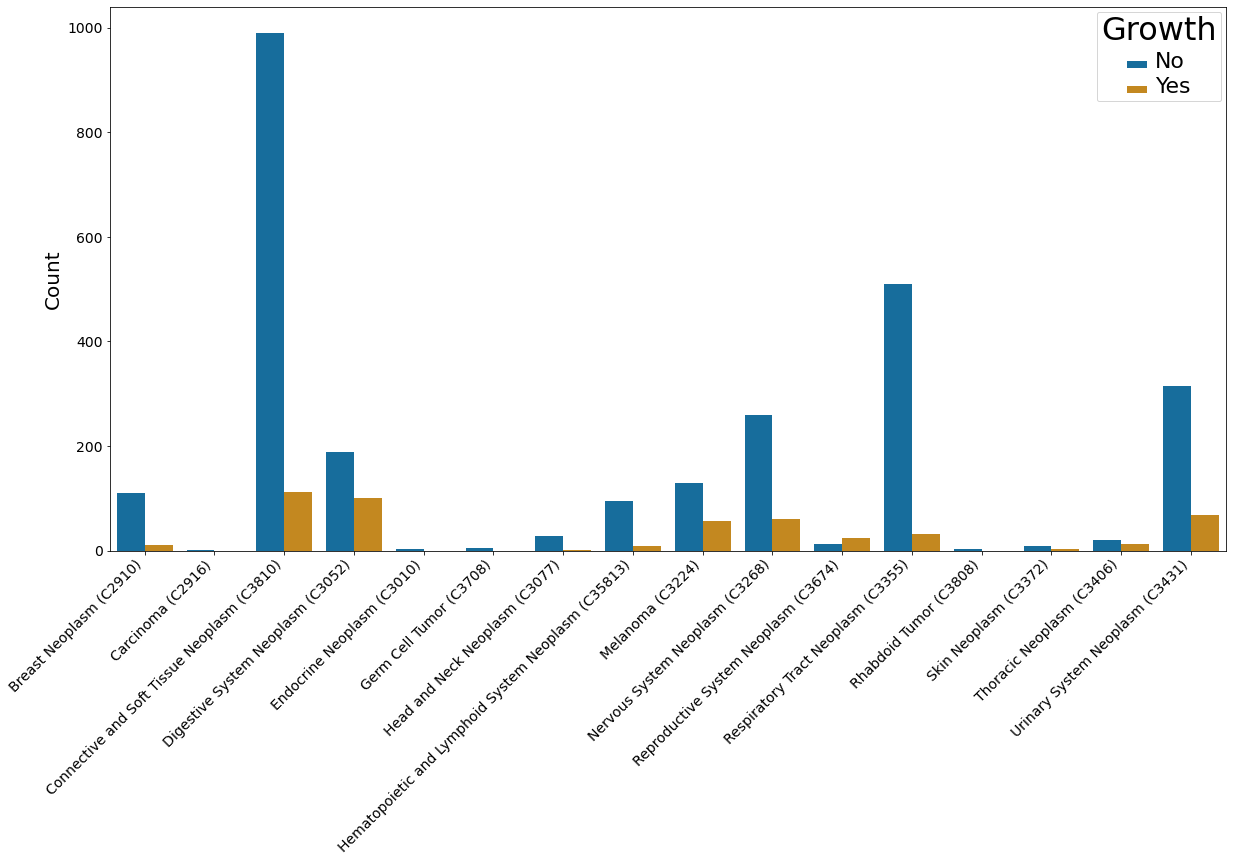

In [289]:
plot_data = test2

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax = sns.barplot(y='Count', x='Disease_highest_level', 
                 data=plot_data, 
                 palette="colorblind",
                 hue='Growth')

ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=20)
ax.set_yticklabels([0, 200, 400, 600, 800, 1000],fontsize=14)
ax.set_xticklabels(labels=plot_data["Disease_highest_level"].unique(), rotation=45, ha='right', fontsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='32')

In [238]:
test.columns

Index(['Cell_Line_Starting_Sample', 'PT-ID', 'SM-ID', 'Status',
       'Resolution_Original', 'Type', 'Primary_Disease', 'Tissue_Site',
       'Tumor_Type', 'Cell_Line', 'Media_type', 'Dimension', 'Flask_coating',
       'Starting_Material_Type', 'Fail_Mode', 'Dataset', 'Resolution',
       'Growth', 'PANEL_renamed_bai_file', 'PANEL_renamed_bam_file',
       'PANEL_depth_of_cov_qc_result', 'PANEL_cnv_calls', 'PANEL_media',
       'PANEL_tn_decision_clean', 'PANEL_filtered_variants',
       'PANEL_mutect1_callstats', 'PANEL_mutect1_coveragewig',
       'PANEL_mutect1_powerwig', 'PANEL_mutect1_vcf', 'PANEL_mutect2_vcf',
       'PANEL_oncotated_maf_mutect1', 'PANEL_oncotated_maf_mutect2',
       'PANEL_Dataset', 'RNA_fastq1', 'RNA_fastq2', 'RNA_bai_file_rna',
       'RNA_bam_file_rna', 'RNA_fusion_predictions',
       'RNA_fusion_predictions_abridged', 'RNA_rnaseqc_count_metrics',
       'RNA_rnaseqc_count_outputs', 'RNA_rnaseqc_exon_counts',
       'RNA_rnaseqc_gene_counts', 'RNA_rnaseqc